# GAN AE Discriminator

### Imports:

In [1]:
from IPython.display import Image, SVG
%matplotlib inline

import time
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Using TensorFlow backend.


***
## Hyperparameters & Options

In [2]:
### DATA SELECTION ###
bkg_filename = "../background_Full_Test3.txt"
sig_filename = "../signal_Full_Test3.txt"
drop_PHI_columns = False
n_train = 25000
scaler = MinMaxScaler()

### OPTIONS ###
savePlots = True
plotsLocation = "./"

### GAN ###
n_epochs = 5000
batch_size = 265
ascent_fraction = 0.02 # if gradient ascent is used

    # Discriminator (AE)
encoding_dim = 3

    ## Generator
noise_dim = 7

***
### Load Data & Preprocessing

In [3]:
bkg_all = pd.read_csv(bkg_filename, delimiter=' ', index_col=False)
sig_all = pd.read_csv(sig_filename, delimiter=' ', index_col=False)

def coordinate_change (df):
    pt1 = np.sqrt(df['px1']**2 + df['py1']**2)
    theta1 = np.arctan2(pt1,df['pz1'])
    eta1 = -1 * np.log(np.tan(theta1/2))
    phi1 = np.arctan2(df['py1'],df['px1'])
    pt2 = np.sqrt(df['px2']**2 + df['py2']**2)
    theta2 = np.arctan2(pt2,df['pz2'])
    eta2 = -1 * np.log(np.tan(theta2/2))
    phi2 = np.arctan2(df['py2'],df['px2'])
    df['px1'] = pt1
    df['py1'] = eta1
    df['pz1'] = phi1
    df['px2'] = pt2
    df['py2'] = eta2
    df['pz2'] = phi2
    df.rename(columns={'px1':'$p_{t1}$', 'py1':'$\eta_{1}$', 'pz1':'$\phi_{1}$', 'px2':'$p_{t2}$',
                       'py2':'$\eta_{2}$', 'pz2':'$\phi_{2}$', 'E1':'$E_1$', 'E2':'$E_2$', 'M1':'$M_1$',
                       'M2':'$M_2$', 'M12':'$M_{1 2}$'}, inplace=True)
    
coordinate_change(sig_all)
coordinate_change(bkg_all)

if drop_PHI_columns:
    sig_sel = sig_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
    bkg_sel = bkg_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
else:
    sig_sel = sig_all
    bkg_sel = bkg_all
    
data_header = list(sig_sel)

sig_shuffled = shuffle(sig_sel)
bkg_shuffled = shuffle(bkg_sel)

n_bkg = len(bkg_sel.iloc[:,:0])
n_sig = len(sig_sel.iloc[:,:0])
f_s = n_train/n_sig
f_b = n_train/n_bkg

print ("Number of BACKGROUND events:", n_bkg)
print ("%0.2f%% = %d" % (f_b*100, n_train), "used for TRAINING")
print ("%.2f%% = %d" % (f_b*100, n_train), "used for TESTING")
print ("%05.2f%% = %d" % ((1-2*f_b)*100, n_bkg - 2*n_train), "unused")
print ("Number of SIGNAL events:", n_sig)
print ("%.2f%% = %d" % (f_s*100, n_train), "used for TESTING")
print ("%.2f%% = %d" % ((1-f_s)*100, n_sig - n_train), "unused")
print ("\n")

sample_train = bkg_sel[:n_train]
sample_test = pd.concat([bkg_sel.iloc[n_train:2*n_train], sig_sel.iloc[:n_train]])
sample_test = sample_test.reset_index(drop=True)

input_dim = sample_train.shape[1]

sample_train = scaler.fit_transform(sample_train)
sample_test = scaler.transform(sample_test)

print('Training sample size: ',sample_train.shape)
print('Testing sample size: ',sample_test.shape)

sample_train_input, sample_train_valid = train_test_split(sample_train,test_size=0.2,random_state=13) 
train_time = 0
n_cycle = 0

Number of BACKGROUND events: 54194
46.13% = 25000 used for TRAINING
46.13% = 25000 used for TESTING
07.74% = 4194 unused
Number of SIGNAL events: 52766
47.38% = 25000 used for TESTING
52.62% = 27766 unused


Training sample size:  (25000, 13)
Testing sample size:  (50000, 13)


### Discriminator (Deep AE)

In [4]:
discriminator = Sequential()

discriminator.add(Dense(3 * encoding_dim, input_shape=(input_dim,), activation='relu', name='encoder_hidden_1'))
discriminator.add(Dense(2 * encoding_dim, activation='relu', name='encoder_hidden_2'))
discriminator.add(Dense(encoding_dim, activation='selu', name='encoder_output'))

discriminator.add(Dense(2 * encoding_dim, activation='relu', name='decoder_hidden_1'))
discriminator.add(Dense(3 * encoding_dim, activation='relu', name='decoder_hidden_2'))
discriminator.add(Dense(input_dim, activation='linear', name='decoder_output'))

discriminator.summary()
discriminator.compile(optimizer='adam', loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_hidden_1 (Dense)     (None, 9)                 126       
_________________________________________________________________
encoder_hidden_2 (Dense)     (None, 6)                 60        
_________________________________________________________________
encoder_output (Dense)       (None, 3)                 21        
_________________________________________________________________
decoder_hidden_1 (Dense)     (None, 6)                 24        
_________________________________________________________________
decoder_hidden_2 (Dense)     (None, 9)                 63        
_________________________________________________________________
decoder_output (Dense)       (None, 13)                130       
Total params: 424
Trainable params: 424
Non-trainable params: 0
_________________________________________________________________


### Generator

In [5]:
generator = Sequential()
generator.add(Dense(10, input_shape=(input_dim,), activation='relu', name='generator_hidden_1'))
generator.add(Dense(20 , activation='relu', name='generator_hidden_2'))
generator.add(Dense(15, activation='relu', name='generator_hidden_3'))
generator.add(Dense(input_dim, activation='sigmoid', name='generator_output'))


generator.summary()
generator.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_hidden_1 (Dense)   (None, 10)                140       
_________________________________________________________________
generator_hidden_2 (Dense)   (None, 20)                220       
_________________________________________________________________
generator_hidden_3 (Dense)   (None, 15)                315       
_________________________________________________________________
generator_output (Dense)     (None, 13)                208       
Total params: 883
Trainable params: 883
Non-trainable params: 0
_________________________________________________________________


### Adversarial Model

In [6]:
input_img_adv = Input(shape=(input_dim,))
AM = Sequential()
output_img_gen = generator.layers[3](generator.layers[2](generator.layers[1](generator.layers[0](input_img_adv))))
output_img_adv = discriminator.layers[5](discriminator.layers[4](discriminator.layers[3](discriminator.layers[2](discriminator.layers[1](discriminator.layers[0](output_img_gen))))))

AM = Model(input_img_adv, output_img_adv)

AM.get_layer('encoder_hidden_1').trainable = False
AM.get_layer('encoder_hidden_2').trainable = False
AM.get_layer('encoder_output').trainable = False
AM.get_layer('decoder_hidden_1').trainable = False
AM.get_layer('decoder_hidden_2').trainable = False
AM.get_layer('decoder_output').trainable = False

AM.compile(loss='mse', optimizer='adam')

AM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13)                0         
_________________________________________________________________
generator_hidden_1 (Dense)   (None, 10)                140       
_________________________________________________________________
generator_hidden_2 (Dense)   (None, 20)                220       
_________________________________________________________________
generator_hidden_3 (Dense)   (None, 15)                315       
_________________________________________________________________
generator_output (Dense)     (None, 13)                208       
_________________________________________________________________
encoder_hidden_1 (Dense)     (None, 9)                 126       
_________________________________________________________________
encoder_hidden_2 (Dense)     (None, 6)                 60        
__________

### Training

In [7]:
discriminator_history = np.empty([n_epochs,2])
adversarial_history = []

gradient_ascent=-ascent_fraction*np.ones(batch_size)


start = time.time()

with tf.device('/CPU:0'):
    for i in range(n_epochs):
        
            #discriminator
            data_train = sample_train[np.random.randint(0,sample_train.shape[0], size=batch_size)]
            noise = np.random.uniform(0, 1.0, size=[batch_size, input_dim])
            data_fake = generator.predict(noise)
            d_loss_data = discriminator.train_on_batch(data_train, data_train)
            
            ### USE THIS FOR GRADIENT ASCENT ###
            d_loss_fake = discriminator.train_on_batch(data_fake, data_fake, sample_weight = gradient_ascent)
            ###
            
            discriminator_history[i]=[d_loss_data, d_loss_fake]
            
            #AM 
            noise = np.random.uniform(0, 1.0, size=[batch_size, input_dim])
            y = generator.predict(noise)
            a_loss = AM.train_on_batch(noise, y)
            adversarial_history.append(a_loss)
            prc = ((i+1)/n_epochs)*100
            log_mesg = "%.2f%% [D loss Real: %f, D loss Fake: %f]" % (prc, d_loss_data, d_loss_fake)
            log_mesg = "%s  [A loss: %f]" % (log_mesg, a_loss)
            print(log_mesg)

end = time.time()
train_time += (end-start)
n_cycle += 1

/home/ioan/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0.02% [D loss Real: 0.101814, D loss Fake: -0.004369]  [A loss: 0.217429]
0.04% [D loss Real: 0.096155, D loss Fake: -0.004319]  [A loss: 0.214649]
0.06% [D loss Real: 0.095929, D loss Fake: -0.004266]  [A loss: 0.211598]
0.08% [D loss Real: 0.090424, D loss Fake: -0.004207]  [A loss: 0.209034]
0.10% [D loss Real: 0.091994, D loss Fake: -0.004150]  [A loss: 0.205904]
0.12% [D loss Real: 0.090458, D loss Fake: -0.004090]  [A loss: 0.202957]
0.14% [D loss Real: 0.085974, D loss Fake: -0.004038]  [A loss: 0.200364]
0.16% [D loss Real: 0.087721, D loss Fake: -0.003975]  [A loss: 0.197616]
0.18% [D loss Real: 0.083711, D loss Fake: -0.003921]  [A loss: 0.194429]
0.20% [D loss Real: 0.082637, D loss Fake: -0.003864]  [A loss: 0.191624]
0.22% [D loss Real: 0.084717, D loss Fake: -0.003801]  [A loss: 0.188643]
0.24% [D loss Real: 0.082246, D loss Fake: -0.003750]  [A loss: 0.185747]
0.26% [D loss Real: 0.078906, D loss Fake: -0.003684]  [A loss: 0.182726]
0.28% [D loss Real: 0.080752, D loss F

2.44% [D loss Real: 0.022065, D loss Fake: -0.002539]  [A loss: 0.127054]
2.46% [D loss Real: 0.022101, D loss Fake: -0.002558]  [A loss: 0.128139]
2.48% [D loss Real: 0.022922, D loss Fake: -0.002544]  [A loss: 0.128144]
2.50% [D loss Real: 0.021919, D loss Fake: -0.002558]  [A loss: 0.128095]
2.52% [D loss Real: 0.022190, D loss Fake: -0.002526]  [A loss: 0.126663]
2.54% [D loss Real: 0.020807, D loss Fake: -0.002562]  [A loss: 0.126306]
2.56% [D loss Real: 0.021602, D loss Fake: -0.002548]  [A loss: 0.126786]
2.58% [D loss Real: 0.021377, D loss Fake: -0.002540]  [A loss: 0.127402]
2.60% [D loss Real: 0.021949, D loss Fake: -0.002528]  [A loss: 0.127529]
2.62% [D loss Real: 0.020981, D loss Fake: -0.002560]  [A loss: 0.126305]
2.64% [D loss Real: 0.022073, D loss Fake: -0.002552]  [A loss: 0.127258]
2.66% [D loss Real: 0.022107, D loss Fake: -0.002559]  [A loss: 0.127770]
2.68% [D loss Real: 0.021357, D loss Fake: -0.002545]  [A loss: 0.127499]
2.70% [D loss Real: 0.020920, D loss F

4.86% [D loss Real: 0.013676, D loss Fake: -0.002415]  [A loss: 0.121992]
4.88% [D loss Real: 0.013283, D loss Fake: -0.002401]  [A loss: 0.120118]
4.90% [D loss Real: 0.012535, D loss Fake: -0.002376]  [A loss: 0.119089]
4.92% [D loss Real: 0.012667, D loss Fake: -0.002369]  [A loss: 0.118245]
4.94% [D loss Real: 0.013325, D loss Fake: -0.002343]  [A loss: 0.116527]
4.96% [D loss Real: 0.012967, D loss Fake: -0.002308]  [A loss: 0.116319]
4.98% [D loss Real: 0.011726, D loss Fake: -0.002297]  [A loss: 0.115355]
5.00% [D loss Real: 0.012126, D loss Fake: -0.002288]  [A loss: 0.113963]
5.02% [D loss Real: 0.011586, D loss Fake: -0.002283]  [A loss: 0.113037]
5.04% [D loss Real: 0.012842, D loss Fake: -0.002247]  [A loss: 0.113066]
5.06% [D loss Real: 0.012021, D loss Fake: -0.002254]  [A loss: 0.111509]
5.08% [D loss Real: 0.012756, D loss Fake: -0.002231]  [A loss: 0.111060]
5.10% [D loss Real: 0.012004, D loss Fake: -0.002236]  [A loss: 0.110941]
5.12% [D loss Real: 0.011135, D loss F

7.34% [D loss Real: 0.010551, D loss Fake: -0.002501]  [A loss: 0.126014]
7.36% [D loss Real: 0.010684, D loss Fake: -0.002444]  [A loss: 0.122679]
7.38% [D loss Real: 0.010930, D loss Fake: -0.002396]  [A loss: 0.120768]
7.40% [D loss Real: 0.010925, D loss Fake: -0.002374]  [A loss: 0.118097]
7.42% [D loss Real: 0.010472, D loss Fake: -0.002327]  [A loss: 0.117926]
7.44% [D loss Real: 0.011128, D loss Fake: -0.002292]  [A loss: 0.114905]
7.46% [D loss Real: 0.010642, D loss Fake: -0.002259]  [A loss: 0.114431]
7.48% [D loss Real: 0.009904, D loss Fake: -0.002229]  [A loss: 0.112062]
7.50% [D loss Real: 0.011398, D loss Fake: -0.002190]  [A loss: 0.110544]
7.52% [D loss Real: 0.010500, D loss Fake: -0.002168]  [A loss: 0.107943]
7.54% [D loss Real: 0.010436, D loss Fake: -0.002120]  [A loss: 0.106398]
7.56% [D loss Real: 0.010726, D loss Fake: -0.002074]  [A loss: 0.104792]
7.58% [D loss Real: 0.011639, D loss Fake: -0.002058]  [A loss: 0.103426]
7.60% [D loss Real: 0.010928, D loss F

9.78% [D loss Real: 0.010380, D loss Fake: -0.001059]  [A loss: 0.053175]
9.80% [D loss Real: 0.009452, D loss Fake: -0.001052]  [A loss: 0.052916]
9.82% [D loss Real: 0.010119, D loss Fake: -0.001048]  [A loss: 0.052947]
9.84% [D loss Real: 0.011173, D loss Fake: -0.001050]  [A loss: 0.053056]
9.86% [D loss Real: 0.010329, D loss Fake: -0.001055]  [A loss: 0.053226]
9.88% [D loss Real: 0.011257, D loss Fake: -0.001059]  [A loss: 0.053533]
9.90% [D loss Real: 0.009340, D loss Fake: -0.001062]  [A loss: 0.053562]
9.92% [D loss Real: 0.009977, D loss Fake: -0.001062]  [A loss: 0.053478]
9.94% [D loss Real: 0.009720, D loss Fake: -0.001057]  [A loss: 0.052867]
9.96% [D loss Real: 0.010480, D loss Fake: -0.001043]  [A loss: 0.052026]
9.98% [D loss Real: 0.010278, D loss Fake: -0.001024]  [A loss: 0.051009]
10.00% [D loss Real: 0.010268, D loss Fake: -0.001009]  [A loss: 0.050401]
10.02% [D loss Real: 0.011028, D loss Fake: -0.000997]  [A loss: 0.049829]
10.04% [D loss Real: 0.009594, D los

12.22% [D loss Real: 0.010557, D loss Fake: -0.001376]  [A loss: 0.068884]
12.24% [D loss Real: 0.009343, D loss Fake: -0.001383]  [A loss: 0.069750]
12.26% [D loss Real: 0.009728, D loss Fake: -0.001394]  [A loss: 0.070072]
12.28% [D loss Real: 0.009999, D loss Fake: -0.001403]  [A loss: 0.070598]
12.30% [D loss Real: 0.010845, D loss Fake: -0.001411]  [A loss: 0.070812]
12.32% [D loss Real: 0.009616, D loss Fake: -0.001416]  [A loss: 0.071069]
12.34% [D loss Real: 0.008942, D loss Fake: -0.001420]  [A loss: 0.071164]
12.36% [D loss Real: 0.009551, D loss Fake: -0.001422]  [A loss: 0.071210]
12.38% [D loss Real: 0.010036, D loss Fake: -0.001421]  [A loss: 0.071303]
12.40% [D loss Real: 0.010227, D loss Fake: -0.001426]  [A loss: 0.071182]
12.42% [D loss Real: 0.011052, D loss Fake: -0.001430]  [A loss: 0.071681]
12.44% [D loss Real: 0.009966, D loss Fake: -0.001432]  [A loss: 0.071978]
12.46% [D loss Real: 0.009041, D loss Fake: -0.001444]  [A loss: 0.072278]
12.48% [D loss Real: 0.00

14.56% [D loss Real: 0.009839, D loss Fake: -0.001292]  [A loss: 0.064757]
14.58% [D loss Real: 0.010046, D loss Fake: -0.001278]  [A loss: 0.063675]
14.60% [D loss Real: 0.009437, D loss Fake: -0.001256]  [A loss: 0.062996]
14.62% [D loss Real: 0.009757, D loss Fake: -0.001236]  [A loss: 0.062221]
14.64% [D loss Real: 0.009966, D loss Fake: -0.001222]  [A loss: 0.061829]
14.66% [D loss Real: 0.009556, D loss Fake: -0.001207]  [A loss: 0.059960]
14.68% [D loss Real: 0.009053, D loss Fake: -0.001182]  [A loss: 0.059432]
14.70% [D loss Real: 0.010439, D loss Fake: -0.001169]  [A loss: 0.058703]
14.72% [D loss Real: 0.009684, D loss Fake: -0.001149]  [A loss: 0.057655]
14.74% [D loss Real: 0.009710, D loss Fake: -0.001117]  [A loss: 0.056296]
14.76% [D loss Real: 0.009058, D loss Fake: -0.001093]  [A loss: 0.054553]
14.78% [D loss Real: 0.009887, D loss Fake: -0.001061]  [A loss: 0.053502]
14.80% [D loss Real: 0.009559, D loss Fake: -0.001030]  [A loss: 0.051729]
14.82% [D loss Real: 0.01

16.96% [D loss Real: 0.010195, D loss Fake: -0.002438]  [A loss: 0.122672]
16.98% [D loss Real: 0.010365, D loss Fake: -0.002474]  [A loss: 0.124747]
17.00% [D loss Real: 0.009429, D loss Fake: -0.002507]  [A loss: 0.125793]
17.02% [D loss Real: 0.010383, D loss Fake: -0.002538]  [A loss: 0.127279]
17.04% [D loss Real: 0.010256, D loss Fake: -0.002592]  [A loss: 0.129758]
17.06% [D loss Real: 0.009021, D loss Fake: -0.002636]  [A loss: 0.132459]
17.08% [D loss Real: 0.010609, D loss Fake: -0.002701]  [A loss: 0.135226]
17.10% [D loss Real: 0.009567, D loss Fake: -0.002743]  [A loss: 0.137960]
17.12% [D loss Real: 0.009656, D loss Fake: -0.002801]  [A loss: 0.140254]
17.14% [D loss Real: 0.010186, D loss Fake: -0.002852]  [A loss: 0.143677]
17.16% [D loss Real: 0.009385, D loss Fake: -0.002910]  [A loss: 0.146853]
17.18% [D loss Real: 0.009337, D loss Fake: -0.002960]  [A loss: 0.149897]
17.20% [D loss Real: 0.009741, D loss Fake: -0.003005]  [A loss: 0.150825]
17.22% [D loss Real: 0.00

19.32% [D loss Real: 0.011172, D loss Fake: -0.009076]  [A loss: 0.477452]
19.34% [D loss Real: 0.011611, D loss Fake: -0.008849]  [A loss: 0.466078]
19.36% [D loss Real: 0.011490, D loss Fake: -0.008576]  [A loss: 0.448654]
19.38% [D loss Real: 0.013382, D loss Fake: -0.008252]  [A loss: 0.431823]
19.40% [D loss Real: 0.011306, D loss Fake: -0.007935]  [A loss: 0.411211]
19.42% [D loss Real: 0.012664, D loss Fake: -0.007519]  [A loss: 0.387902]
19.44% [D loss Real: 0.012093, D loss Fake: -0.007059]  [A loss: 0.364391]
19.46% [D loss Real: 0.011768, D loss Fake: -0.006520]  [A loss: 0.333989]
19.48% [D loss Real: 0.011978, D loss Fake: -0.005929]  [A loss: 0.306464]
19.50% [D loss Real: 0.011347, D loss Fake: -0.005459]  [A loss: 0.282099]
19.52% [D loss Real: 0.012770, D loss Fake: -0.004902]  [A loss: 0.250829]
19.54% [D loss Real: 0.011786, D loss Fake: -0.004343]  [A loss: 0.222502]
19.56% [D loss Real: 0.012580, D loss Fake: -0.003830]  [A loss: 0.197020]
19.58% [D loss Real: 0.01

21.54% [D loss Real: 0.009681, D loss Fake: -0.002795]  [A loss: 0.141988]
21.56% [D loss Real: 0.010488, D loss Fake: -0.002826]  [A loss: 0.144006]
21.58% [D loss Real: 0.010823, D loss Fake: -0.002833]  [A loss: 0.145219]
21.60% [D loss Real: 0.009925, D loss Fake: -0.002900]  [A loss: 0.147679]
21.62% [D loss Real: 0.012133, D loss Fake: -0.002911]  [A loss: 0.148677]
21.64% [D loss Real: 0.010228, D loss Fake: -0.002883]  [A loss: 0.147001]
21.66% [D loss Real: 0.011288, D loss Fake: -0.002824]  [A loss: 0.144466]
21.68% [D loss Real: 0.009444, D loss Fake: -0.002759]  [A loss: 0.137757]
21.70% [D loss Real: 0.010241, D loss Fake: -0.002739]  [A loss: 0.139843]
21.72% [D loss Real: 0.011519, D loss Fake: -0.002740]  [A loss: 0.138110]
21.74% [D loss Real: 0.010628, D loss Fake: -0.002694]  [A loss: 0.136754]
21.76% [D loss Real: 0.010327, D loss Fake: -0.002643]  [A loss: 0.135953]
21.78% [D loss Real: 0.010109, D loss Fake: -0.002556]  [A loss: 0.131138]
21.80% [D loss Real: 0.01

23.74% [D loss Real: 0.009725, D loss Fake: -0.000556]  [A loss: 0.027905]
23.76% [D loss Real: 0.008843, D loss Fake: -0.000549]  [A loss: 0.027657]
23.78% [D loss Real: 0.009945, D loss Fake: -0.000559]  [A loss: 0.027953]
23.80% [D loss Real: 0.008854, D loss Fake: -0.000566]  [A loss: 0.028908]
23.82% [D loss Real: 0.009542, D loss Fake: -0.000574]  [A loss: 0.028710]
23.84% [D loss Real: 0.009543, D loss Fake: -0.000577]  [A loss: 0.028395]
23.86% [D loss Real: 0.009774, D loss Fake: -0.000568]  [A loss: 0.028961]
23.88% [D loss Real: 0.009660, D loss Fake: -0.000580]  [A loss: 0.029102]
23.90% [D loss Real: 0.010794, D loss Fake: -0.000579]  [A loss: 0.029108]
23.92% [D loss Real: 0.010038, D loss Fake: -0.000587]  [A loss: 0.028812]
23.94% [D loss Real: 0.010172, D loss Fake: -0.000579]  [A loss: 0.028269]
23.96% [D loss Real: 0.009194, D loss Fake: -0.000572]  [A loss: 0.028833]
23.98% [D loss Real: 0.009957, D loss Fake: -0.000570]  [A loss: 0.028453]
24.00% [D loss Real: 0.00

25.96% [D loss Real: 0.011813, D loss Fake: -0.000821]  [A loss: 0.040994]
25.98% [D loss Real: 0.009024, D loss Fake: -0.000813]  [A loss: 0.040639]
26.00% [D loss Real: 0.009618, D loss Fake: -0.000810]  [A loss: 0.040360]
26.02% [D loss Real: 0.010438, D loss Fake: -0.000795]  [A loss: 0.040547]
26.04% [D loss Real: 0.010102, D loss Fake: -0.000794]  [A loss: 0.040455]
26.06% [D loss Real: 0.008635, D loss Fake: -0.000796]  [A loss: 0.039524]
26.08% [D loss Real: 0.009269, D loss Fake: -0.000808]  [A loss: 0.040240]
26.10% [D loss Real: 0.009386, D loss Fake: -0.000785]  [A loss: 0.039856]
26.12% [D loss Real: 0.010348, D loss Fake: -0.000776]  [A loss: 0.039359]
26.14% [D loss Real: 0.009800, D loss Fake: -0.000774]  [A loss: 0.039177]
26.16% [D loss Real: 0.009284, D loss Fake: -0.000773]  [A loss: 0.039153]
26.18% [D loss Real: 0.009626, D loss Fake: -0.000763]  [A loss: 0.038403]
26.20% [D loss Real: 0.009805, D loss Fake: -0.000755]  [A loss: 0.038444]
26.22% [D loss Real: 0.00

28.22% [D loss Real: 0.009501, D loss Fake: -0.001899]  [A loss: 0.094312]
28.24% [D loss Real: 0.008224, D loss Fake: -0.001886]  [A loss: 0.094255]
28.26% [D loss Real: 0.008778, D loss Fake: -0.001895]  [A loss: 0.095722]
28.28% [D loss Real: 0.009779, D loss Fake: -0.001894]  [A loss: 0.095572]
28.30% [D loss Real: 0.010782, D loss Fake: -0.001917]  [A loss: 0.096108]
28.32% [D loss Real: 0.010206, D loss Fake: -0.001893]  [A loss: 0.096494]
28.34% [D loss Real: 0.009082, D loss Fake: -0.001919]  [A loss: 0.095410]
28.36% [D loss Real: 0.010950, D loss Fake: -0.001899]  [A loss: 0.095787]
28.38% [D loss Real: 0.009447, D loss Fake: -0.001891]  [A loss: 0.095650]
28.40% [D loss Real: 0.009143, D loss Fake: -0.001897]  [A loss: 0.095771]
28.42% [D loss Real: 0.009474, D loss Fake: -0.001902]  [A loss: 0.095321]
28.44% [D loss Real: 0.008528, D loss Fake: -0.001885]  [A loss: 0.095597]
28.46% [D loss Real: 0.010180, D loss Fake: -0.001897]  [A loss: 0.095934]
28.48% [D loss Real: 0.00

30.68% [D loss Real: 0.009320, D loss Fake: -0.001735]  [A loss: 0.086807]
30.70% [D loss Real: 0.010214, D loss Fake: -0.001734]  [A loss: 0.085880]
30.72% [D loss Real: 0.010029, D loss Fake: -0.001697]  [A loss: 0.085064]
30.74% [D loss Real: 0.009212, D loss Fake: -0.001690]  [A loss: 0.084255]
30.76% [D loss Real: 0.009037, D loss Fake: -0.001685]  [A loss: 0.083589]
30.78% [D loss Real: 0.008574, D loss Fake: -0.001644]  [A loss: 0.082964]
30.80% [D loss Real: 0.009864, D loss Fake: -0.001636]  [A loss: 0.081727]
30.82% [D loss Real: 0.008879, D loss Fake: -0.001625]  [A loss: 0.081129]
30.84% [D loss Real: 0.008850, D loss Fake: -0.001609]  [A loss: 0.080215]
30.86% [D loss Real: 0.009611, D loss Fake: -0.001580]  [A loss: 0.079087]
30.88% [D loss Real: 0.009564, D loss Fake: -0.001550]  [A loss: 0.078335]
30.90% [D loss Real: 0.008415, D loss Fake: -0.001524]  [A loss: 0.076858]
30.92% [D loss Real: 0.008905, D loss Fake: -0.001486]  [A loss: 0.074696]
30.94% [D loss Real: 0.00

32.92% [D loss Real: 0.010412, D loss Fake: -0.000297]  [A loss: 0.014892]
32.94% [D loss Real: 0.010159, D loss Fake: -0.000286]  [A loss: 0.014232]
32.96% [D loss Real: 0.008525, D loss Fake: -0.000280]  [A loss: 0.014430]
32.98% [D loss Real: 0.009103, D loss Fake: -0.000278]  [A loss: 0.014016]
33.00% [D loss Real: 0.008650, D loss Fake: -0.000275]  [A loss: 0.014052]
33.02% [D loss Real: 0.009914, D loss Fake: -0.000274]  [A loss: 0.013536]
33.04% [D loss Real: 0.009751, D loss Fake: -0.000269]  [A loss: 0.013251]
33.06% [D loss Real: 0.009040, D loss Fake: -0.000260]  [A loss: 0.013253]
33.08% [D loss Real: 0.009777, D loss Fake: -0.000257]  [A loss: 0.013052]
33.10% [D loss Real: 0.009252, D loss Fake: -0.000253]  [A loss: 0.012624]
33.12% [D loss Real: 0.009353, D loss Fake: -0.000253]  [A loss: 0.012316]
33.14% [D loss Real: 0.008606, D loss Fake: -0.000245]  [A loss: 0.012497]
33.16% [D loss Real: 0.010024, D loss Fake: -0.000239]  [A loss: 0.012121]
33.18% [D loss Real: 0.01

35.28% [D loss Real: 0.009435, D loss Fake: -0.000252]  [A loss: 0.012814]
35.30% [D loss Real: 0.009918, D loss Fake: -0.000255]  [A loss: 0.012402]
35.32% [D loss Real: 0.010118, D loss Fake: -0.000251]  [A loss: 0.012753]
35.34% [D loss Real: 0.008901, D loss Fake: -0.000248]  [A loss: 0.012404]
35.36% [D loss Real: 0.009467, D loss Fake: -0.000252]  [A loss: 0.012420]
35.38% [D loss Real: 0.009132, D loss Fake: -0.000248]  [A loss: 0.012383]
35.40% [D loss Real: 0.010179, D loss Fake: -0.000252]  [A loss: 0.012532]
35.42% [D loss Real: 0.009405, D loss Fake: -0.000245]  [A loss: 0.012342]
35.44% [D loss Real: 0.009044, D loss Fake: -0.000251]  [A loss: 0.012619]
35.46% [D loss Real: 0.009209, D loss Fake: -0.000249]  [A loss: 0.012590]
35.48% [D loss Real: 0.009296, D loss Fake: -0.000247]  [A loss: 0.012433]
35.50% [D loss Real: 0.009304, D loss Fake: -0.000250]  [A loss: 0.012625]
35.52% [D loss Real: 0.009873, D loss Fake: -0.000253]  [A loss: 0.012691]
35.54% [D loss Real: 0.01

37.50% [D loss Real: 0.009071, D loss Fake: -0.000391]  [A loss: 0.019612]
37.52% [D loss Real: 0.009713, D loss Fake: -0.000391]  [A loss: 0.019700]
37.54% [D loss Real: 0.009771, D loss Fake: -0.000395]  [A loss: 0.019821]
37.56% [D loss Real: 0.008727, D loss Fake: -0.000398]  [A loss: 0.020033]
37.58% [D loss Real: 0.010456, D loss Fake: -0.000403]  [A loss: 0.020360]
37.60% [D loss Real: 0.009856, D loss Fake: -0.000407]  [A loss: 0.020434]
37.62% [D loss Real: 0.009896, D loss Fake: -0.000417]  [A loss: 0.020881]
37.64% [D loss Real: 0.009390, D loss Fake: -0.000427]  [A loss: 0.021430]
37.66% [D loss Real: 0.008814, D loss Fake: -0.000439]  [A loss: 0.022035]
37.68% [D loss Real: 0.008547, D loss Fake: -0.000452]  [A loss: 0.022552]
37.70% [D loss Real: 0.009556, D loss Fake: -0.000463]  [A loss: 0.023336]
37.72% [D loss Real: 0.010114, D loss Fake: -0.000477]  [A loss: 0.023842]
37.74% [D loss Real: 0.009671, D loss Fake: -0.000492]  [A loss: 0.024806]
37.76% [D loss Real: 0.00

39.70% [D loss Real: 0.008781, D loss Fake: -0.001527]  [A loss: 0.076451]
39.72% [D loss Real: 0.009719, D loss Fake: -0.001539]  [A loss: 0.077843]
39.74% [D loss Real: 0.009612, D loss Fake: -0.001563]  [A loss: 0.077925]
39.76% [D loss Real: 0.009651, D loss Fake: -0.001582]  [A loss: 0.078332]
39.78% [D loss Real: 0.010399, D loss Fake: -0.001581]  [A loss: 0.079453]
39.80% [D loss Real: 0.009273, D loss Fake: -0.001584]  [A loss: 0.079932]
39.82% [D loss Real: 0.009004, D loss Fake: -0.001602]  [A loss: 0.080129]
39.84% [D loss Real: 0.008927, D loss Fake: -0.001598]  [A loss: 0.080598]
39.86% [D loss Real: 0.009725, D loss Fake: -0.001609]  [A loss: 0.080335]
39.88% [D loss Real: 0.009178, D loss Fake: -0.001605]  [A loss: 0.080503]
39.90% [D loss Real: 0.009676, D loss Fake: -0.001605]  [A loss: 0.080995]
39.92% [D loss Real: 0.009532, D loss Fake: -0.001602]  [A loss: 0.081141]
39.94% [D loss Real: 0.009235, D loss Fake: -0.001603]  [A loss: 0.081177]
39.96% [D loss Real: 0.00

41.94% [D loss Real: 0.008603, D loss Fake: -0.000493]  [A loss: 0.024743]
41.96% [D loss Real: 0.008182, D loss Fake: -0.000491]  [A loss: 0.025180]
41.98% [D loss Real: 0.009570, D loss Fake: -0.000520]  [A loss: 0.026807]
42.00% [D loss Real: 0.008289, D loss Fake: -0.000535]  [A loss: 0.026954]
42.02% [D loss Real: 0.010449, D loss Fake: -0.000534]  [A loss: 0.027099]
42.04% [D loss Real: 0.010027, D loss Fake: -0.000567]  [A loss: 0.026995]
42.06% [D loss Real: 0.008905, D loss Fake: -0.000556]  [A loss: 0.027797]
42.08% [D loss Real: 0.009061, D loss Fake: -0.000565]  [A loss: 0.027585]
42.10% [D loss Real: 0.009622, D loss Fake: -0.000561]  [A loss: 0.028361]
42.12% [D loss Real: 0.008224, D loss Fake: -0.000560]  [A loss: 0.028711]
42.14% [D loss Real: 0.010386, D loss Fake: -0.000573]  [A loss: 0.028182]
42.16% [D loss Real: 0.009117, D loss Fake: -0.000571]  [A loss: 0.027942]
42.18% [D loss Real: 0.009016, D loss Fake: -0.000569]  [A loss: 0.028458]
42.20% [D loss Real: 0.01

44.46% [D loss Real: 0.009495, D loss Fake: -0.000531]  [A loss: 0.026683]
44.48% [D loss Real: 0.009933, D loss Fake: -0.000534]  [A loss: 0.026713]
44.50% [D loss Real: 0.009327, D loss Fake: -0.000531]  [A loss: 0.026842]
44.52% [D loss Real: 0.009269, D loss Fake: -0.000531]  [A loss: 0.026700]
44.54% [D loss Real: 0.009364, D loss Fake: -0.000536]  [A loss: 0.027018]
44.56% [D loss Real: 0.009645, D loss Fake: -0.000538]  [A loss: 0.026547]
44.58% [D loss Real: 0.008758, D loss Fake: -0.000522]  [A loss: 0.026316]
44.60% [D loss Real: 0.008440, D loss Fake: -0.000528]  [A loss: 0.026705]
44.62% [D loss Real: 0.009795, D loss Fake: -0.000526]  [A loss: 0.026595]
44.64% [D loss Real: 0.009576, D loss Fake: -0.000524]  [A loss: 0.026236]
44.66% [D loss Real: 0.009072, D loss Fake: -0.000518]  [A loss: 0.026026]
44.68% [D loss Real: 0.009683, D loss Fake: -0.000515]  [A loss: 0.025654]
44.70% [D loss Real: 0.009277, D loss Fake: -0.000513]  [A loss: 0.025713]
44.72% [D loss Real: 0.00

46.88% [D loss Real: 0.009095, D loss Fake: -0.000171]  [A loss: 0.008673]
46.90% [D loss Real: 0.008768, D loss Fake: -0.000176]  [A loss: 0.008725]
46.92% [D loss Real: 0.009873, D loss Fake: -0.000174]  [A loss: 0.008673]
46.94% [D loss Real: 0.010397, D loss Fake: -0.000173]  [A loss: 0.008690]
46.96% [D loss Real: 0.009314, D loss Fake: -0.000174]  [A loss: 0.008591]
46.98% [D loss Real: 0.008788, D loss Fake: -0.000168]  [A loss: 0.008584]
47.00% [D loss Real: 0.009977, D loss Fake: -0.000165]  [A loss: 0.008337]
47.02% [D loss Real: 0.010961, D loss Fake: -0.000165]  [A loss: 0.008510]
47.04% [D loss Real: 0.009765, D loss Fake: -0.000168]  [A loss: 0.008487]
47.06% [D loss Real: 0.008975, D loss Fake: -0.000174]  [A loss: 0.008602]
47.08% [D loss Real: 0.008784, D loss Fake: -0.000175]  [A loss: 0.008732]
47.10% [D loss Real: 0.008918, D loss Fake: -0.000176]  [A loss: 0.008937]
47.12% [D loss Real: 0.009207, D loss Fake: -0.000178]  [A loss: 0.009091]
47.14% [D loss Real: 0.00

49.24% [D loss Real: 0.010050, D loss Fake: -0.000172]  [A loss: 0.008579]
49.26% [D loss Real: 0.010050, D loss Fake: -0.000169]  [A loss: 0.008433]
49.28% [D loss Real: 0.008983, D loss Fake: -0.000168]  [A loss: 0.008672]
49.30% [D loss Real: 0.008224, D loss Fake: -0.000172]  [A loss: 0.008518]
49.32% [D loss Real: 0.009222, D loss Fake: -0.000176]  [A loss: 0.008877]
49.34% [D loss Real: 0.008701, D loss Fake: -0.000178]  [A loss: 0.008853]
49.36% [D loss Real: 0.009083, D loss Fake: -0.000178]  [A loss: 0.009054]
49.38% [D loss Real: 0.009267, D loss Fake: -0.000173]  [A loss: 0.008628]
49.40% [D loss Real: 0.009409, D loss Fake: -0.000167]  [A loss: 0.007929]
49.42% [D loss Real: 0.009111, D loss Fake: -0.000159]  [A loss: 0.008203]
49.44% [D loss Real: 0.009561, D loss Fake: -0.000164]  [A loss: 0.008057]
49.46% [D loss Real: 0.009224, D loss Fake: -0.000162]  [A loss: 0.008111]
49.48% [D loss Real: 0.009731, D loss Fake: -0.000167]  [A loss: 0.008201]
49.50% [D loss Real: 0.01

51.50% [D loss Real: 0.008384, D loss Fake: -0.000180]  [A loss: 0.009280]
51.52% [D loss Real: 0.009279, D loss Fake: -0.000182]  [A loss: 0.009161]
51.54% [D loss Real: 0.009370, D loss Fake: -0.000186]  [A loss: 0.009357]
51.56% [D loss Real: 0.009795, D loss Fake: -0.000185]  [A loss: 0.009311]
51.58% [D loss Real: 0.008766, D loss Fake: -0.000185]  [A loss: 0.009350]
51.60% [D loss Real: 0.009253, D loss Fake: -0.000187]  [A loss: 0.009172]
51.62% [D loss Real: 0.009506, D loss Fake: -0.000184]  [A loss: 0.008927]
51.64% [D loss Real: 0.008674, D loss Fake: -0.000176]  [A loss: 0.008770]
51.66% [D loss Real: 0.009700, D loss Fake: -0.000176]  [A loss: 0.008701]
51.68% [D loss Real: 0.008580, D loss Fake: -0.000173]  [A loss: 0.008684]
51.70% [D loss Real: 0.009442, D loss Fake: -0.000173]  [A loss: 0.008705]
51.72% [D loss Real: 0.009449, D loss Fake: -0.000176]  [A loss: 0.008557]
51.74% [D loss Real: 0.009359, D loss Fake: -0.000173]  [A loss: 0.008773]
51.76% [D loss Real: 0.00

53.98% [D loss Real: 0.008769, D loss Fake: -0.000175]  [A loss: 0.008852]
54.00% [D loss Real: 0.008039, D loss Fake: -0.000174]  [A loss: 0.008911]
54.02% [D loss Real: 0.009057, D loss Fake: -0.000180]  [A loss: 0.008826]
54.04% [D loss Real: 0.009075, D loss Fake: -0.000178]  [A loss: 0.008909]
54.06% [D loss Real: 0.008817, D loss Fake: -0.000182]  [A loss: 0.009164]
54.08% [D loss Real: 0.009393, D loss Fake: -0.000183]  [A loss: 0.009098]
54.10% [D loss Real: 0.009429, D loss Fake: -0.000183]  [A loss: 0.009167]
54.12% [D loss Real: 0.008684, D loss Fake: -0.000185]  [A loss: 0.009201]
54.14% [D loss Real: 0.010051, D loss Fake: -0.000184]  [A loss: 0.009192]
54.16% [D loss Real: 0.010284, D loss Fake: -0.000189]  [A loss: 0.009626]
54.18% [D loss Real: 0.008089, D loss Fake: -0.000191]  [A loss: 0.009532]
54.20% [D loss Real: 0.009220, D loss Fake: -0.000189]  [A loss: 0.009663]
54.22% [D loss Real: 0.008651, D loss Fake: -0.000194]  [A loss: 0.009496]
54.24% [D loss Real: 0.00

56.28% [D loss Real: 0.009614, D loss Fake: -0.000203]  [A loss: 0.009945]
56.30% [D loss Real: 0.009509, D loss Fake: -0.000204]  [A loss: 0.010050]
56.32% [D loss Real: 0.008827, D loss Fake: -0.000200]  [A loss: 0.009877]
56.34% [D loss Real: 0.009107, D loss Fake: -0.000198]  [A loss: 0.009858]
56.36% [D loss Real: 0.009506, D loss Fake: -0.000200]  [A loss: 0.010054]
56.38% [D loss Real: 0.009485, D loss Fake: -0.000199]  [A loss: 0.010234]
56.40% [D loss Real: 0.008395, D loss Fake: -0.000204]  [A loss: 0.010261]
56.42% [D loss Real: 0.008418, D loss Fake: -0.000210]  [A loss: 0.010529]
56.44% [D loss Real: 0.008550, D loss Fake: -0.000208]  [A loss: 0.010303]
56.46% [D loss Real: 0.009301, D loss Fake: -0.000207]  [A loss: 0.010336]
56.48% [D loss Real: 0.008980, D loss Fake: -0.000207]  [A loss: 0.010575]
56.50% [D loss Real: 0.009499, D loss Fake: -0.000209]  [A loss: 0.010679]
56.52% [D loss Real: 0.007736, D loss Fake: -0.000210]  [A loss: 0.010544]
56.54% [D loss Real: 0.00

58.80% [D loss Real: 0.008770, D loss Fake: -0.000260]  [A loss: 0.013312]
58.82% [D loss Real: 0.009294, D loss Fake: -0.000255]  [A loss: 0.012853]
58.84% [D loss Real: 0.007856, D loss Fake: -0.000256]  [A loss: 0.013017]
58.86% [D loss Real: 0.010653, D loss Fake: -0.000255]  [A loss: 0.012820]
58.88% [D loss Real: 0.008864, D loss Fake: -0.000256]  [A loss: 0.012871]
58.90% [D loss Real: 0.009554, D loss Fake: -0.000256]  [A loss: 0.012832]
58.92% [D loss Real: 0.009517, D loss Fake: -0.000263]  [A loss: 0.013282]
58.94% [D loss Real: 0.008813, D loss Fake: -0.000267]  [A loss: 0.013242]
58.96% [D loss Real: 0.009516, D loss Fake: -0.000265]  [A loss: 0.013525]
58.98% [D loss Real: 0.009389, D loss Fake: -0.000266]  [A loss: 0.013329]
59.00% [D loss Real: 0.009186, D loss Fake: -0.000268]  [A loss: 0.013366]
59.02% [D loss Real: 0.010176, D loss Fake: -0.000270]  [A loss: 0.013416]
59.04% [D loss Real: 0.009200, D loss Fake: -0.000266]  [A loss: 0.013358]
59.06% [D loss Real: 0.00

61.28% [D loss Real: 0.009206, D loss Fake: -0.000254]  [A loss: 0.012871]
61.30% [D loss Real: 0.008339, D loss Fake: -0.000254]  [A loss: 0.012981]
61.32% [D loss Real: 0.009243, D loss Fake: -0.000257]  [A loss: 0.012745]
61.34% [D loss Real: 0.008723, D loss Fake: -0.000261]  [A loss: 0.013301]
61.36% [D loss Real: 0.009089, D loss Fake: -0.000262]  [A loss: 0.013651]
61.38% [D loss Real: 0.008448, D loss Fake: -0.000269]  [A loss: 0.013775]
61.40% [D loss Real: 0.010095, D loss Fake: -0.000267]  [A loss: 0.013406]
61.42% [D loss Real: 0.009756, D loss Fake: -0.000268]  [A loss: 0.013464]
61.44% [D loss Real: 0.008146, D loss Fake: -0.000266]  [A loss: 0.013300]
61.46% [D loss Real: 0.009159, D loss Fake: -0.000272]  [A loss: 0.013612]
61.48% [D loss Real: 0.009042, D loss Fake: -0.000266]  [A loss: 0.013796]
61.50% [D loss Real: 0.009318, D loss Fake: -0.000272]  [A loss: 0.013302]
61.52% [D loss Real: 0.009322, D loss Fake: -0.000266]  [A loss: 0.013215]
61.54% [D loss Real: 0.00

63.50% [D loss Real: 0.009351, D loss Fake: -0.000236]  [A loss: 0.011682]
63.52% [D loss Real: 0.009094, D loss Fake: -0.000238]  [A loss: 0.011928]
63.54% [D loss Real: 0.008506, D loss Fake: -0.000245]  [A loss: 0.012317]
63.56% [D loss Real: 0.009987, D loss Fake: -0.000252]  [A loss: 0.012454]
63.58% [D loss Real: 0.009540, D loss Fake: -0.000252]  [A loss: 0.012379]
63.60% [D loss Real: 0.008624, D loss Fake: -0.000249]  [A loss: 0.012426]
63.62% [D loss Real: 0.009150, D loss Fake: -0.000240]  [A loss: 0.011822]
63.64% [D loss Real: 0.009735, D loss Fake: -0.000231]  [A loss: 0.011350]
63.66% [D loss Real: 0.008820, D loss Fake: -0.000220]  [A loss: 0.011096]
63.68% [D loss Real: 0.010029, D loss Fake: -0.000214]  [A loss: 0.010751]
63.70% [D loss Real: 0.009056, D loss Fake: -0.000211]  [A loss: 0.010436]
63.72% [D loss Real: 0.009645, D loss Fake: -0.000211]  [A loss: 0.010697]
63.74% [D loss Real: 0.011772, D loss Fake: -0.000217]  [A loss: 0.010825]
63.76% [D loss Real: 0.00

65.74% [D loss Real: 0.008958, D loss Fake: -0.000257]  [A loss: 0.012952]
65.76% [D loss Real: 0.009586, D loss Fake: -0.000257]  [A loss: 0.013150]
65.78% [D loss Real: 0.009045, D loss Fake: -0.000268]  [A loss: 0.013297]
65.80% [D loss Real: 0.009178, D loss Fake: -0.000266]  [A loss: 0.013287]
65.82% [D loss Real: 0.007664, D loss Fake: -0.000268]  [A loss: 0.013151]
65.84% [D loss Real: 0.008400, D loss Fake: -0.000260]  [A loss: 0.013172]
65.86% [D loss Real: 0.008960, D loss Fake: -0.000259]  [A loss: 0.012619]
65.88% [D loss Real: 0.009010, D loss Fake: -0.000254]  [A loss: 0.012595]
65.90% [D loss Real: 0.008210, D loss Fake: -0.000254]  [A loss: 0.012610]
65.92% [D loss Real: 0.009465, D loss Fake: -0.000255]  [A loss: 0.012525]
65.94% [D loss Real: 0.009568, D loss Fake: -0.000256]  [A loss: 0.012841]
65.96% [D loss Real: 0.009458, D loss Fake: -0.000251]  [A loss: 0.012751]
65.98% [D loss Real: 0.009443, D loss Fake: -0.000258]  [A loss: 0.012666]
66.00% [D loss Real: 0.00

68.28% [D loss Real: 0.009726, D loss Fake: -0.000322]  [A loss: 0.016241]
68.30% [D loss Real: 0.009507, D loss Fake: -0.000326]  [A loss: 0.016467]
68.32% [D loss Real: 0.008412, D loss Fake: -0.000334]  [A loss: 0.016598]
68.34% [D loss Real: 0.009400, D loss Fake: -0.000337]  [A loss: 0.017025]
68.36% [D loss Real: 0.008932, D loss Fake: -0.000341]  [A loss: 0.017396]
68.38% [D loss Real: 0.008949, D loss Fake: -0.000344]  [A loss: 0.017175]
68.40% [D loss Real: 0.009080, D loss Fake: -0.000347]  [A loss: 0.017343]
68.42% [D loss Real: 0.009369, D loss Fake: -0.000340]  [A loss: 0.017139]
68.44% [D loss Real: 0.008626, D loss Fake: -0.000339]  [A loss: 0.016705]
68.46% [D loss Real: 0.009708, D loss Fake: -0.000338]  [A loss: 0.016640]
68.48% [D loss Real: 0.009303, D loss Fake: -0.000334]  [A loss: 0.016953]
68.50% [D loss Real: 0.009270, D loss Fake: -0.000336]  [A loss: 0.016880]
68.52% [D loss Real: 0.007666, D loss Fake: -0.000339]  [A loss: 0.017054]
68.54% [D loss Real: 0.00

70.74% [D loss Real: 0.009273, D loss Fake: -0.000423]  [A loss: 0.020960]
70.76% [D loss Real: 0.009159, D loss Fake: -0.000412]  [A loss: 0.021043]
70.78% [D loss Real: 0.009386, D loss Fake: -0.000418]  [A loss: 0.021159]
70.80% [D loss Real: 0.010156, D loss Fake: -0.000412]  [A loss: 0.021005]
70.82% [D loss Real: 0.008588, D loss Fake: -0.000417]  [A loss: 0.020558]
70.84% [D loss Real: 0.009135, D loss Fake: -0.000410]  [A loss: 0.020768]
70.86% [D loss Real: 0.008711, D loss Fake: -0.000417]  [A loss: 0.020897]
70.88% [D loss Real: 0.010153, D loss Fake: -0.000415]  [A loss: 0.021025]
70.90% [D loss Real: 0.008564, D loss Fake: -0.000413]  [A loss: 0.020858]
70.92% [D loss Real: 0.008735, D loss Fake: -0.000414]  [A loss: 0.020906]
70.94% [D loss Real: 0.008723, D loss Fake: -0.000414]  [A loss: 0.020803]
70.96% [D loss Real: 0.009220, D loss Fake: -0.000414]  [A loss: 0.020560]
70.98% [D loss Real: 0.009692, D loss Fake: -0.000417]  [A loss: 0.020650]
71.00% [D loss Real: 0.00

73.26% [D loss Real: 0.009830, D loss Fake: -0.000356]  [A loss: 0.017935]
73.28% [D loss Real: 0.008959, D loss Fake: -0.000358]  [A loss: 0.017937]
73.30% [D loss Real: 0.009019, D loss Fake: -0.000358]  [A loss: 0.017811]
73.32% [D loss Real: 0.009724, D loss Fake: -0.000355]  [A loss: 0.017771]
73.34% [D loss Real: 0.009146, D loss Fake: -0.000354]  [A loss: 0.017677]
73.36% [D loss Real: 0.009756, D loss Fake: -0.000351]  [A loss: 0.017679]
73.38% [D loss Real: 0.007995, D loss Fake: -0.000352]  [A loss: 0.017531]
73.40% [D loss Real: 0.009171, D loss Fake: -0.000357]  [A loss: 0.018046]
73.42% [D loss Real: 0.007821, D loss Fake: -0.000361]  [A loss: 0.018402]
73.44% [D loss Real: 0.008789, D loss Fake: -0.000374]  [A loss: 0.018870]
73.46% [D loss Real: 0.010000, D loss Fake: -0.000378]  [A loss: 0.018997]
73.48% [D loss Real: 0.008683, D loss Fake: -0.000382]  [A loss: 0.019100]
73.50% [D loss Real: 0.009511, D loss Fake: -0.000381]  [A loss: 0.018976]
73.52% [D loss Real: 0.00

75.54% [D loss Real: 0.009718, D loss Fake: -0.000362]  [A loss: 0.018011]
75.56% [D loss Real: 0.009788, D loss Fake: -0.000361]  [A loss: 0.018180]
75.58% [D loss Real: 0.008449, D loss Fake: -0.000362]  [A loss: 0.018311]
75.60% [D loss Real: 0.008732, D loss Fake: -0.000365]  [A loss: 0.018237]
75.62% [D loss Real: 0.008578, D loss Fake: -0.000366]  [A loss: 0.018291]
75.64% [D loss Real: 0.009114, D loss Fake: -0.000367]  [A loss: 0.018286]
75.66% [D loss Real: 0.010042, D loss Fake: -0.000366]  [A loss: 0.018091]
75.68% [D loss Real: 0.009439, D loss Fake: -0.000363]  [A loss: 0.018306]
75.70% [D loss Real: 0.008638, D loss Fake: -0.000364]  [A loss: 0.018367]
75.72% [D loss Real: 0.008499, D loss Fake: -0.000363]  [A loss: 0.018152]
75.74% [D loss Real: 0.009957, D loss Fake: -0.000361]  [A loss: 0.018330]
75.76% [D loss Real: 0.009665, D loss Fake: -0.000365]  [A loss: 0.018391]
75.78% [D loss Real: 0.010688, D loss Fake: -0.000367]  [A loss: 0.018414]
75.80% [D loss Real: 0.00

77.76% [D loss Real: 0.009032, D loss Fake: -0.000180]  [A loss: 0.009449]
77.78% [D loss Real: 0.009453, D loss Fake: -0.000173]  [A loss: 0.008809]
77.80% [D loss Real: 0.009228, D loss Fake: -0.000163]  [A loss: 0.008144]
77.82% [D loss Real: 0.009007, D loss Fake: -0.000160]  [A loss: 0.008508]
77.84% [D loss Real: 0.008547, D loss Fake: -0.000158]  [A loss: 0.008180]
77.86% [D loss Real: 0.009744, D loss Fake: -0.000149]  [A loss: 0.007856]
77.88% [D loss Real: 0.009603, D loss Fake: -0.000143]  [A loss: 0.006989]
77.90% [D loss Real: 0.010052, D loss Fake: -0.000134]  [A loss: 0.006776]
77.92% [D loss Real: 0.008814, D loss Fake: -0.000131]  [A loss: 0.006423]
77.94% [D loss Real: 0.009176, D loss Fake: -0.000123]  [A loss: 0.006149]
77.96% [D loss Real: 0.008172, D loss Fake: -0.000118]  [A loss: 0.005894]
77.98% [D loss Real: 0.009620, D loss Fake: -0.000109]  [A loss: 0.005510]
78.00% [D loss Real: 0.008716, D loss Fake: -0.000105]  [A loss: 0.005704]
78.02% [D loss Real: 0.01

80.24% [D loss Real: 0.008885, D loss Fake: -0.000133]  [A loss: 0.006612]
80.26% [D loss Real: 0.009831, D loss Fake: -0.000135]  [A loss: 0.006644]
80.28% [D loss Real: 0.008302, D loss Fake: -0.000131]  [A loss: 0.006537]
80.30% [D loss Real: 0.009118, D loss Fake: -0.000129]  [A loss: 0.006470]
80.32% [D loss Real: 0.008820, D loss Fake: -0.000128]  [A loss: 0.006443]
80.34% [D loss Real: 0.009209, D loss Fake: -0.000126]  [A loss: 0.006243]
80.36% [D loss Real: 0.009215, D loss Fake: -0.000124]  [A loss: 0.006247]
80.38% [D loss Real: 0.009745, D loss Fake: -0.000126]  [A loss: 0.006361]
80.40% [D loss Real: 0.008769, D loss Fake: -0.000130]  [A loss: 0.006761]
80.42% [D loss Real: 0.009024, D loss Fake: -0.000137]  [A loss: 0.006948]
80.44% [D loss Real: 0.008508, D loss Fake: -0.000140]  [A loss: 0.007110]
80.46% [D loss Real: 0.008770, D loss Fake: -0.000141]  [A loss: 0.007084]
80.48% [D loss Real: 0.009065, D loss Fake: -0.000140]  [A loss: 0.007030]
80.50% [D loss Real: 0.00

82.56% [D loss Real: 0.008098, D loss Fake: -0.000225]  [A loss: 0.011085]
82.58% [D loss Real: 0.009742, D loss Fake: -0.000223]  [A loss: 0.011104]
82.60% [D loss Real: 0.009835, D loss Fake: -0.000222]  [A loss: 0.011065]
82.62% [D loss Real: 0.007735, D loss Fake: -0.000219]  [A loss: 0.010871]
82.64% [D loss Real: 0.009987, D loss Fake: -0.000217]  [A loss: 0.010619]
82.66% [D loss Real: 0.008682, D loss Fake: -0.000213]  [A loss: 0.010832]
82.68% [D loss Real: 0.008688, D loss Fake: -0.000211]  [A loss: 0.010778]
82.70% [D loss Real: 0.009840, D loss Fake: -0.000214]  [A loss: 0.010650]
82.72% [D loss Real: 0.009215, D loss Fake: -0.000209]  [A loss: 0.010504]
82.74% [D loss Real: 0.009142, D loss Fake: -0.000208]  [A loss: 0.010287]
82.76% [D loss Real: 0.008772, D loss Fake: -0.000205]  [A loss: 0.010304]
82.78% [D loss Real: 0.008709, D loss Fake: -0.000206]  [A loss: 0.010302]
82.80% [D loss Real: 0.008904, D loss Fake: -0.000208]  [A loss: 0.010574]
82.82% [D loss Real: 0.00

85.08% [D loss Real: 0.008871, D loss Fake: -0.000313]  [A loss: 0.015551]
85.10% [D loss Real: 0.008532, D loss Fake: -0.000318]  [A loss: 0.016019]
85.12% [D loss Real: 0.009281, D loss Fake: -0.000320]  [A loss: 0.016443]
85.14% [D loss Real: 0.009991, D loss Fake: -0.000332]  [A loss: 0.017121]
85.16% [D loss Real: 0.009845, D loss Fake: -0.000341]  [A loss: 0.017170]
85.18% [D loss Real: 0.009710, D loss Fake: -0.000337]  [A loss: 0.016974]
85.20% [D loss Real: 0.008691, D loss Fake: -0.000333]  [A loss: 0.016682]
85.22% [D loss Real: 0.008446, D loss Fake: -0.000323]  [A loss: 0.016222]
85.24% [D loss Real: 0.007584, D loss Fake: -0.000319]  [A loss: 0.015496]
85.26% [D loss Real: 0.009346, D loss Fake: -0.000306]  [A loss: 0.015147]
85.28% [D loss Real: 0.009412, D loss Fake: -0.000303]  [A loss: 0.014948]
85.30% [D loss Real: 0.008723, D loss Fake: -0.000301]  [A loss: 0.014934]
85.32% [D loss Real: 0.008308, D loss Fake: -0.000302]  [A loss: 0.015194]
85.34% [D loss Real: 0.00

87.34% [D loss Real: 0.009507, D loss Fake: -0.000376]  [A loss: 0.018801]
87.36% [D loss Real: 0.009327, D loss Fake: -0.000376]  [A loss: 0.018786]
87.38% [D loss Real: 0.009332, D loss Fake: -0.000378]  [A loss: 0.018858]
87.40% [D loss Real: 0.008077, D loss Fake: -0.000376]  [A loss: 0.018787]
87.42% [D loss Real: 0.009369, D loss Fake: -0.000373]  [A loss: 0.018246]
87.44% [D loss Real: 0.008080, D loss Fake: -0.000360]  [A loss: 0.017896]
87.46% [D loss Real: 0.010034, D loss Fake: -0.000356]  [A loss: 0.017802]
87.48% [D loss Real: 0.009046, D loss Fake: -0.000356]  [A loss: 0.018063]
87.50% [D loss Real: 0.009971, D loss Fake: -0.000358]  [A loss: 0.018191]
87.52% [D loss Real: 0.009232, D loss Fake: -0.000373]  [A loss: 0.018449]
87.54% [D loss Real: 0.009869, D loss Fake: -0.000378]  [A loss: 0.018933]
87.56% [D loss Real: 0.007819, D loss Fake: -0.000380]  [A loss: 0.018954]
87.58% [D loss Real: 0.009124, D loss Fake: -0.000384]  [A loss: 0.019393]
87.60% [D loss Real: 0.00

89.68% [D loss Real: 0.009286, D loss Fake: -0.000469]  [A loss: 0.023448]
89.70% [D loss Real: 0.009455, D loss Fake: -0.000461]  [A loss: 0.022917]
89.72% [D loss Real: 0.008995, D loss Fake: -0.000449]  [A loss: 0.022100]
89.74% [D loss Real: 0.009159, D loss Fake: -0.000436]  [A loss: 0.021649]
89.76% [D loss Real: 0.008804, D loss Fake: -0.000429]  [A loss: 0.020993]
89.78% [D loss Real: 0.008910, D loss Fake: -0.000410]  [A loss: 0.020514]
89.80% [D loss Real: 0.009694, D loss Fake: -0.000407]  [A loss: 0.020284]
89.82% [D loss Real: 0.008944, D loss Fake: -0.000400]  [A loss: 0.019846]
89.84% [D loss Real: 0.008750, D loss Fake: -0.000398]  [A loss: 0.019696]
89.86% [D loss Real: 0.009058, D loss Fake: -0.000394]  [A loss: 0.019923]
89.88% [D loss Real: 0.009207, D loss Fake: -0.000395]  [A loss: 0.020055]
89.90% [D loss Real: 0.008950, D loss Fake: -0.000404]  [A loss: 0.020352]
89.92% [D loss Real: 0.009148, D loss Fake: -0.000410]  [A loss: 0.020982]
89.94% [D loss Real: 0.00

91.94% [D loss Real: 0.008984, D loss Fake: -0.000438]  [A loss: 0.021704]
91.96% [D loss Real: 0.009220, D loss Fake: -0.000429]  [A loss: 0.021622]
91.98% [D loss Real: 0.009628, D loss Fake: -0.000430]  [A loss: 0.021332]
92.00% [D loss Real: 0.010578, D loss Fake: -0.000424]  [A loss: 0.021358]
92.02% [D loss Real: 0.009398, D loss Fake: -0.000428]  [A loss: 0.021341]
92.04% [D loss Real: 0.010008, D loss Fake: -0.000427]  [A loss: 0.021878]
92.06% [D loss Real: 0.007881, D loss Fake: -0.000429]  [A loss: 0.021625]
92.08% [D loss Real: 0.009503, D loss Fake: -0.000437]  [A loss: 0.021910]
92.10% [D loss Real: 0.009180, D loss Fake: -0.000445]  [A loss: 0.022461]
92.12% [D loss Real: 0.009374, D loss Fake: -0.000449]  [A loss: 0.022801]
92.14% [D loss Real: 0.009144, D loss Fake: -0.000449]  [A loss: 0.022371]
92.16% [D loss Real: 0.009495, D loss Fake: -0.000445]  [A loss: 0.022233]
92.18% [D loss Real: 0.008318, D loss Fake: -0.000432]  [A loss: 0.021702]
92.20% [D loss Real: 0.00

94.20% [D loss Real: 0.009063, D loss Fake: -0.000467]  [A loss: 0.023338]
94.22% [D loss Real: 0.009059, D loss Fake: -0.000464]  [A loss: 0.022810]
94.24% [D loss Real: 0.008499, D loss Fake: -0.000452]  [A loss: 0.022243]
94.26% [D loss Real: 0.008655, D loss Fake: -0.000435]  [A loss: 0.021617]
94.28% [D loss Real: 0.009644, D loss Fake: -0.000431]  [A loss: 0.021472]
94.30% [D loss Real: 0.009775, D loss Fake: -0.000427]  [A loss: 0.021854]
94.32% [D loss Real: 0.009579, D loss Fake: -0.000437]  [A loss: 0.022743]
94.34% [D loss Real: 0.008880, D loss Fake: -0.000453]  [A loss: 0.022920]
94.36% [D loss Real: 0.009473, D loss Fake: -0.000462]  [A loss: 0.023626]
94.38% [D loss Real: 0.008721, D loss Fake: -0.000470]  [A loss: 0.023813]
94.40% [D loss Real: 0.009214, D loss Fake: -0.000472]  [A loss: 0.023933]
94.42% [D loss Real: 0.009091, D loss Fake: -0.000472]  [A loss: 0.024044]
94.44% [D loss Real: 0.008011, D loss Fake: -0.000475]  [A loss: 0.023575]
94.46% [D loss Real: 0.00

96.48% [D loss Real: 0.008778, D loss Fake: -0.000541]  [A loss: 0.027550]
96.50% [D loss Real: 0.009088, D loss Fake: -0.000545]  [A loss: 0.027059]
96.52% [D loss Real: 0.008282, D loss Fake: -0.000544]  [A loss: 0.027087]
96.54% [D loss Real: 0.009860, D loss Fake: -0.000537]  [A loss: 0.027014]
96.56% [D loss Real: 0.009252, D loss Fake: -0.000534]  [A loss: 0.027231]
96.58% [D loss Real: 0.008555, D loss Fake: -0.000538]  [A loss: 0.027145]
96.60% [D loss Real: 0.009546, D loss Fake: -0.000537]  [A loss: 0.026967]
96.62% [D loss Real: 0.008513, D loss Fake: -0.000539]  [A loss: 0.026768]
96.64% [D loss Real: 0.009187, D loss Fake: -0.000534]  [A loss: 0.026907]
96.66% [D loss Real: 0.008739, D loss Fake: -0.000532]  [A loss: 0.026837]
96.68% [D loss Real: 0.009488, D loss Fake: -0.000534]  [A loss: 0.026994]
96.70% [D loss Real: 0.010659, D loss Fake: -0.000530]  [A loss: 0.026683]
96.72% [D loss Real: 0.008430, D loss Fake: -0.000528]  [A loss: 0.026582]
96.74% [D loss Real: 0.00

98.72% [D loss Real: 0.009174, D loss Fake: -0.000425]  [A loss: 0.021550]
98.74% [D loss Real: 0.009918, D loss Fake: -0.000423]  [A loss: 0.021454]
98.76% [D loss Real: 0.008914, D loss Fake: -0.000424]  [A loss: 0.021444]
98.78% [D loss Real: 0.008602, D loss Fake: -0.000418]  [A loss: 0.021435]
98.80% [D loss Real: 0.009242, D loss Fake: -0.000422]  [A loss: 0.021777]
98.82% [D loss Real: 0.007712, D loss Fake: -0.000428]  [A loss: 0.021607]
98.84% [D loss Real: 0.008600, D loss Fake: -0.000429]  [A loss: 0.021804]
98.86% [D loss Real: 0.007942, D loss Fake: -0.000417]  [A loss: 0.021188]
98.88% [D loss Real: 0.007451, D loss Fake: -0.000407]  [A loss: 0.020539]
98.90% [D loss Real: 0.009208, D loss Fake: -0.000404]  [A loss: 0.020157]
98.92% [D loss Real: 0.008620, D loss Fake: -0.000396]  [A loss: 0.020058]
98.94% [D loss Real: 0.008681, D loss Fake: -0.000395]  [A loss: 0.019918]
98.96% [D loss Real: 0.008436, D loss Fake: -0.000392]  [A loss: 0.019825]
98.98% [D loss Real: 0.00

### Loss

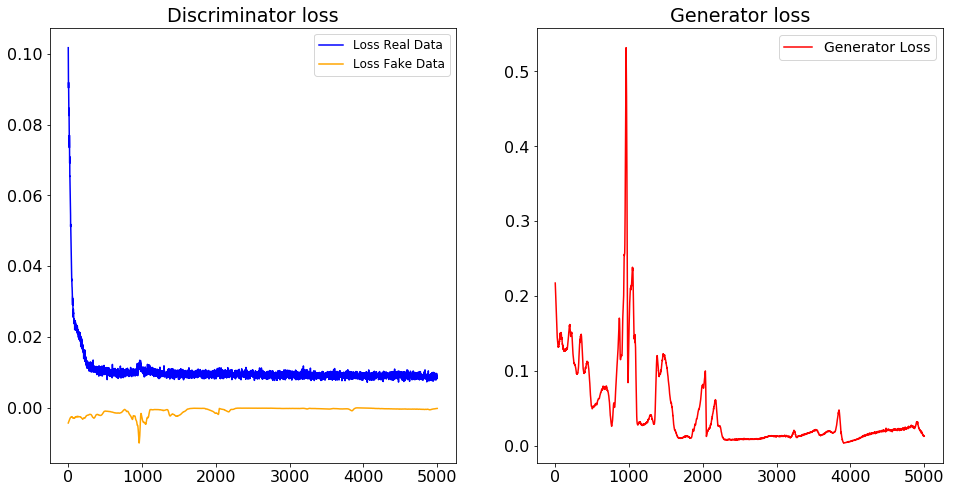

In [8]:
epochs = range(n_epochs)
file_name = "%dcylce" % (n_cycle)
plt.rcParams.update({'font.size': 16})

lossFig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, discriminator_history[:,0], 'b', label='Loss Real Data')
plt.plot(epochs, discriminator_history[:,1], 'orange', label='Loss Fake Data')
plt.title('Discriminator loss')
plt.legend(loc="best", prop={'size': 12})
plt.subplot(1, 2, 2)
plt.plot(epochs, adversarial_history, 'r', label='Generator Loss')
plt.title('Generator loss')
plt.legend(loc="best", prop={'size': 14})
plt.show()

if savePlots:
    lossFig.savefig(plotsLocation + file_name + "Loss.png")

### Distances

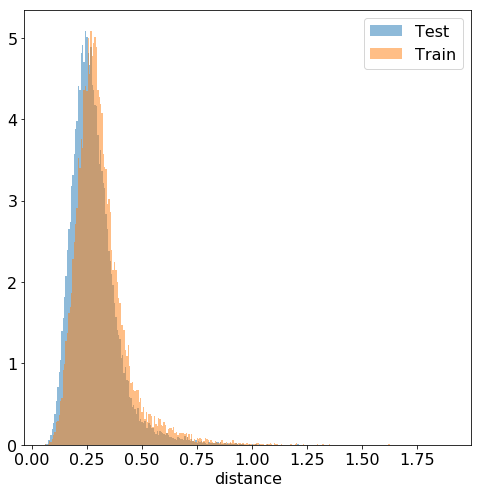

In [9]:
decoded_imgs = discriminator.predict(sample_test)
decoded_imgs_train = discriminator.predict(sample_train)

norm_test=[]
for i in range(sample_test.shape[0]):
    norm_test += [norm(sample_test[i,:]-decoded_imgs[i,:])]

norm_train=[]
for i in range(sample_train.shape[0]):
    norm_train += [norm(sample_train[i,:]-decoded_imgs_train[i,:])]


plt.figure(figsize=(8, 8))
n, bins, patches = plt.hist(norm_test, bins='auto', alpha=0.5, label='Test', density=True)
plt.hist(norm_train, bins, alpha=0.5, label='Train', density=True)
plt.xlabel('distance')
plt.legend(loc='upper right')

if savePlots:
    plt.savefig(plotsLocation + file_name + "Distances.png")

### ROC

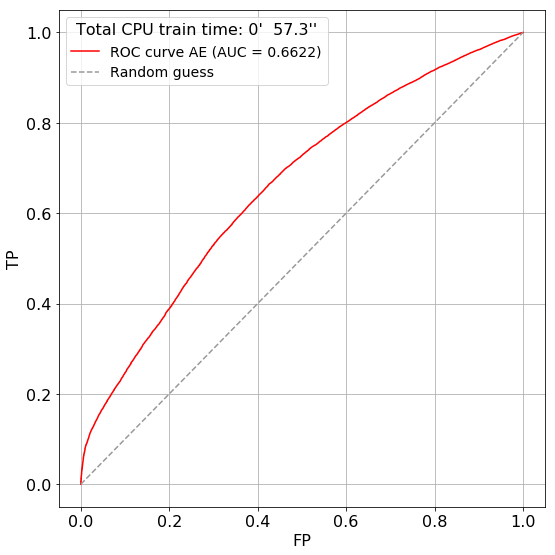

In [10]:
target = np.concatenate((np.zeros(sample_train.shape[0] + n_train),np.ones(n_train)))
scores = np.concatenate((norm_train,norm_test))  

train_min = int(train_time) // 60
train_sec = train_time - 60 * train_min
time_stamp = "Total CPU train time: %d'  %.1f''" % (train_min, train_sec)

plt.figure(figsize=(8, 8))
                   
fp, vp, thresholds = roc_curve(target,scores,pos_label=0)
roc_auc = auc(fp, vp)

plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))

plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1],
         linestyle='--',color=(0.6, 0.6, 0.6),
         label='Random guess')
plt.grid()
plt.legend(loc="best", title =time_stamp, prop={'size': 14})
plt.tight_layout()

if savePlots:
    plt.savefig(plotsLocation + file_name + "ROC.png")

### Save Generator

In [11]:
generator_json = generator.to_json()
with open("generator.json", "w") as json_file:
    json_file.write(generator_json)

generator.save_weights("generator.h5")